# 第十二章 pandas高级应用

In [36]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

# 12.1 分类数据

In [2]:
import numpy as np; import pandas as pd
values = pd.Series(['apple', 'orange', 'apple',
                    'apple'] * 2)
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [3]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [4]:
pd.value_counts(values)

apple     6
orange    2
dtype: int64

- 许多数据系统（数据仓库、统计计算或其它应用）都发展出了特定的表征重复值的
方法，以进行高效的存储和计算。在数据仓库中，最好的方法是使用所谓的包含不
同值的维表(Dimension Table)，将主要的参数存储为引用维表整数键：

In [17]:
values = pd.Series([0, 1, 0, 0] * 2)
dim = pd.Series(['apple', 'orange'])
values

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64

In [18]:
dim

0     apple
1    orange
dtype: object

In [19]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

这种用整数表示的方法称为分类或字典编码表示法。不同值得数组称为分类、字典
或数据级。本书中，我们使用分类的说法。表示分类的整数值称为分类编码或简单
地称为编码。
分类表示可以在进行分析时大大的提高性能。你也可以在保持编码不变的情况下，
对分类进行转换。一些相对简单的转变例子包括：
- 重命名分类。
- 加入一个新的分类，不改变已经存在的分类的顺序或位置

## pandas的分类类型
pandas有一个特殊的分类类型astype('category')，用于保存使用整数分类表示法的数据。

In [20]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2
N = len(fruits)
df = pd.DataFrame({'fruit':fruits,'basket_id':np.arange(N),
                  'count':np.random.randint(3,16,size=N),
                  'weight':np.random.uniform(0,4,size=N)})
df

,basket_id,count,fruit,weight
0,0,8,apple,2.614279
1,1,5,orange,2.990859
2,2,4,apple,3.845227
3,3,9,apple,0.033553
4,4,4,apple,0.425778
5,5,14,orange,1.194815
6,6,12,apple,2.625645
7,7,14,apple,3.239250


In [21]:
fruit_cat = df['fruit'].astype('category')
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): [apple, orange]

- fruit_cat的值不是NumPy数组，而是一个pandas.Categorical实例：

In [22]:
c = fruit_cat.values
type(c)

pandas.core.arrays.categorical.Categorical

In [24]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [25]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

In [26]:
dir(c)

['T',
 '__array__',
 '__array_priority__',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_can_hold_na',
 '_codes',
 '_codes_for_groupby',
 '_concat_same_type',
 '_constructor',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_dtype',
 '_formatting_values',
 '_from_factorized',
 '_from_inferred_categories',
 '_from_sequence',
 '_get_codes',
 '_get_repr',
 '_maybe_coerce_indexer',
 '_ndarray_values',
 '_reduce',
 '_repr_categories',
 '_repr_categories_info',
 '_repr_footer',
 '_reset_cache',
 '_reverse_indexer',
 '_set_categories',
 '_set_codes',
 '_set_dtype',
 

- pd.Categorical从其它Python序列直接创建


In [27]:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])
my_categories

[foo, bar, baz, foo, bar]
Categories (3, object): [bar, baz, foo]

- 如果已经从其它源获得了分类编码，你还可以使用from_codes构造器：

In [28]:
categories = ['foo', 'bar', 'baz']
codes = [0, 1, 2, 0, 0, 1]
my_cats_2 = pd.Categorical.from_codes(codes=codes,categories=categories)
my_cats_2

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo, bar, baz]

- 与显示指定不同，分类变换不认定指定的分类顺序。因此取决于输入数据的顺序，
categories数组的顺序会不同。当使用from_codes或其它的构造器时，你可以指
定分类一个有意义的顺序

In [29]:
ordered_cat = pd.Categorical.from_codes(codes, categories,
                                        ordered=True)
ordered_cat

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

- 输出[foo < bar < baz]指明‘foo’位于‘bar’的前面，以此类推。无序的分类
实例可以通过as_ordered排序

In [31]:
my_cats_2.as_ordered()

[foo, bar, baz, foo, foo, bar]
Categories (3, object): [foo < bar < baz]

## 用分类进行计算
- 与非编码版本（比如字符串数组）相比，使用pandas的Categorical有些类似。
- 某些pandas组件，比如groupby函数，更适合进行分类。还有一些函数可以使用有
序标志位。
- 来看一些随机的数值数据，使用pandas.qcut面元函数。它会返回pandas.Categorical，
- 之前使用过pandas.cut，但没解释分类是如何工作的：

In [33]:
np.random.seed(12345)
draws = np.random.randn(1000)
draws[:5]

array([-0.2047,  0.4789, -0.5194, -0.5557,  1.9658])

In [34]:
bins = pd.qcut(draws,4)
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] < (0.63, 3.928]]

In [35]:
bins.value_counts()

(-2.9499999999999997, -0.684]    250
(-0.684, -0.0101]                250
(-0.0101, 0.63]                  250
(0.63, 3.928]                    250
dtype: int64

- 确切的样本分位数与分位的名称相比，不利于生成汇总。我们可以使用
labels参数qcut，实现目的

In [37]:
bins = pd.qcut(draws,4,labels=['Q1', 'Q2', 'Q3', 'Q4'])
bins

[Q2, Q3, Q2, Q2, Q4, ..., Q3, Q2, Q1, Q3, Q4]
Length: 1000
Categories (4, object): [Q1 < Q2 < Q3 < Q4]

In [39]:
bins = pd.Series(bins, name='quartile')
results = (pd.Series(draws)
           .groupby(bins)
           .agg(['count', 'min', 'max']))
results

,count,min,max
quartile,,,
Q1,250,-2.949343,-0.685484
Q2,250,-0.683066,-0.010115
Q3,250,-0.010032,0.628894
Q4,250,0.634238,3.927528


In [40]:
bins = pd.Series(bins, name='quartile')
results = (pd.Series(draws)
           .groupby(bins)
           .agg(['count', 'min', 'max']))
results

,count,min,max
quartile,,,
Q1,250,-2.949343,-0.685484
Q2,250,-0.683066,-0.010115
Q3,250,-0.010032,0.628894
Q4,250,0.634238,3.927528


## 用分类提高性能
一个特定数据集上做大量分析，将其转换为分类可以极大地提高效率。
DataFrame列的分类使用的内存通常少的多。

In [44]:
N = 10000000
draws = pd.Series(np.random.randn(N))
labels = pd.Series(['foo', 'bar', 'baz', 'qux']).take(np.random.randint(0,3,N))     
labels

2    baz
0    foo
0    foo
1    bar
2    baz
1    bar
2    baz
2    baz
1    bar
1    bar
    ... 
2    baz
0    foo
1    bar
0    foo
0    foo
1    bar
2    baz
2    baz
0    foo
1    bar
Length: 10000000, dtype: object

- 将标签转换为分类——1

In [45]:
categories = pd.Categorical(labels)
categories

[baz, foo, foo, bar, baz, ..., bar, baz, baz, foo, bar]
Length: 10000000
Categories (3, object): [bar, baz, foo]

- 将标签转换为分类——2

In [46]:
categories = labels.astype('category')
categories.head()

2    baz
0    foo
0    foo
1    bar
2    baz
dtype: category
Categories (3, object): [bar, baz, foo]

- 对比分类结果和labels的内存使用
- 分类结果内存用的非常少

In [51]:
print(categories.memory_usage())
print(labels.memory_usage())
print(pd.Categorical(labels).memory_usage())
print(labels.astype('category').memory_usage())

90000104
160000000
10000104
90000104


- 转换为分类不是没有代价的，但这是一次性的代价：

In [49]:
%time _ = labels.astype('category')

Wall time: 381 ms


## 分类方法


In [52]:
s = pd.Series(['a', 'b', 'c', 'd'] * 2)
cat_s = s.astype('category')
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): [a, b, c, d]

- cat属性提供了分类方法的入口：

In [53]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [54]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

- 假设我们知道这个数据的实际分类集，超出了数据中的四个值。我们可以使用
set_categories方法改变它们：

In [56]:
actual_categories = ['a', 'b', 'c', 'd', 'e']
cats_s2 = cat_s.cat.set_categories(actual_categories)
cats_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): [a, b, c, d, e]

- 虽然数据看起来没变，新的分类将反映在它们的操作中。

In [57]:
cat_s.value_counts()

d    2
c    2
b    2
a    2
dtype: int64

In [58]:
cats_s2.value_counts()

d    2
c    2
b    2
a    2
e    0
dtype: int64

- 在大数据集中，分类经常作为节省内存和高性能的便捷工具。过滤完大
DataFrame或Series之后，许多分类可能不会出现在数据中。我们可以使用
remove_unused_categories方法删除没看到的分类

In [59]:
cats_s3 = cat_s[cat_s.isin(['a','b'])]
cats_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): [a, b, c, d]

In [60]:
cats_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): [a, b]

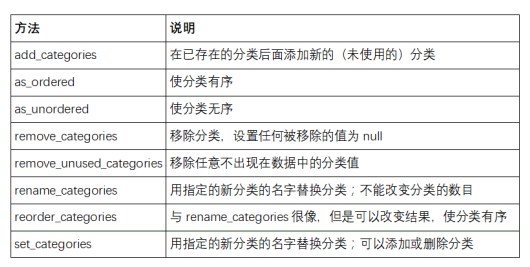

## 为建模创建虚拟变量

- 当使用统计或机器学习工具时，通常会将分类数据转换为虚拟变量，也称为
one-hot编码。这包括创建一个不同类别的列的DataFrame；这些列包含给定分
类的1s，其它为0。

In [73]:
cat_s = pd.Series(['a','b','c','d']*2, dtype="category")
help(pd.Series)

Help on class Series in module pandas.core.series:

class Series(pandas.core.base.IndexOpsMixin, pandas.core.generic.NDFrame)
 |  One-dimensional ndarray with axis labels (including time series).
 |  
 |  Labels need not be unique but must be a hashable type. The object
 |  supports both integer- and label-based indexing and provides a host of
 |  methods for performing operations involving the index. Statistical
 |  methods from ndarray have been overridden to automatically exclude
 |  missing data (currently represented as NaN).
 |  
 |  Operations between Series (+, -, /, *, **) align values based on their
 |  associated index values-- they need not be the same length. The result
 |  index will be the sorted union of the two indexes.
 |  
 |  Parameters
 |  ----------
 |  data : array-like, dict, or scalar value
 |      Contains data stored in Series
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, argument order is maintained for Python 3.6
 |         and late

- pandas.get_dummies函数可以转换这个分类数据为包含虚
拟变量的DataFrame

In [74]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


# 12.2 GroupBy高级应用

## 分组转换和“解封”GroupBy

我们在分组操作中学习了apply方法，进行转换。还有另一个
transform方法，它与apply很像，但是对使用的函数有一定限制：
- 它可以产生向分组形状广播标量值
- 它可以产生一个和输入组形状相同的对象
- 它不能修改输入

In [75]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4,
                   'value': np.arange(12.)})
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


In [83]:
g = df.groupby('key')

print(type(g.mean()))
g.mean()

<class 'pandas.core.frame.DataFrame'>


,value
key,
a,4.5
b,5.5
c,6.5


In [84]:
g = df.groupby('key')['value']
print(type(g.mean()))
g.mean()

<class 'pandas.core.series.Series'>


key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

In [85]:
g = df.groupby('key').value
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

- 假设我们想产生一个和df['value']形状相同的Series，但值替换为按键分组的平均
值。我们可以传递函数lambda x: x.mean()进行转换：

In [92]:
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

- 对于内置的聚合函数，我们可以传递一个字符串假名作为GroupBy的agg方法：

In [93]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

In [94]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

In [96]:
g.transform(lambda x: x + 1)

0      1.0
1      2.0
2      3.0
3      4.0
4      5.0
5      6.0
6      7.0
7      8.0
8      9.0
9     10.0
10    11.0
11    12.0
Name: value, dtype: float64

In [98]:
print(dir(g))

['__bytes__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '__weakref__', '_accessors', '_add_numeric_operations', '_agg_doc', '_aggregate', '_aggregate_multiple_funcs', '_aggregate_named', '_apply_filter', '_apply_to_column_groupbys', '_apply_whitelist', '_assure_grouper', '_bool_agg', '_builtin_table', '_concat_objects', '_constructor', '_cumcount_array', '_cython_agg_general', '_cython_table', '_cython_transform', '_def_str', '_deprecations', '_dir_additions', '_dir_deletions', '_fill', '_get_cythonized_result', '_get_index', '_get_indices', '_gotitem', '_group_selection', '_internal_names', '_internal_names_set', '_is_builtin_func', '_is_cython_func', '_ite

In [99]:
g.first()

key
a    0.0
b    1.0
c    2.0
Name: value, dtype: float64

In [101]:
help(g)

Help on SeriesGroupBy in module pandas.core.groupby.groupby object:

class SeriesGroupBy(GroupBy)
 |  Class for grouping and aggregating relational data. See aggregate,
 |  transform, and apply functions on this object.
 |  
 |  It's easiest to use obj.groupby(...) to use GroupBy, but you can also do:
 |  
 |  ::
 |  
 |      grouped = groupby(obj, ...)
 |  
 |  Parameters
 |  ----------
 |  obj : pandas object
 |  axis : int, default 0
 |  level : int, default None
 |      Level of MultiIndex
 |  groupings : list of Grouping objects
 |      Most users should ignore this
 |  exclusions : array-like, optional
 |      List of columns to exclude
 |  name : string
 |      Most users should ignore this
 |  
 |  Notes
 |  -----
 |  After grouping, see aggregate, apply, and transform functions. Here are
 |  some other brief notes about usage. When grouping by multiple groups, the
 |  result index will be a MultiIndex (hierarchical) by default.
 |  
 |  Iteration produces (key, group) tuples, 

In [102]:
def normalize(x):
    return (x - x.mean()) / x.std()

In [103]:
g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [104]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [105]:
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


## 分组的时间重采样

In [109]:
N = 15
times = pd.date_range('2017-05-20 00:00', freq='1min', periods=N)
df = pd.DataFrame({'time':times,
                  'value': np.arange(N)})
df

,time,value
0,2017-05-20 00:00:00,0
1,2017-05-20 00:01:00,1
2,2017-05-20 00:02:00,2
3,2017-05-20 00:03:00,3
4,2017-05-20 00:04:00,4
5,2017-05-20 00:05:00,5
6,2017-05-20 00:06:00,6
7,2017-05-20 00:07:00,7
8,2017-05-20 00:08:00,8
9,2017-05-20 00:09:00,9


In [110]:
# 使用time做为索引
df.set_index('time').resample('5min').count()

,value
time,
2017-05-20 00:00:00,5
2017-05-20 00:05:00,5
2017-05-20 00:10:00,5


In [111]:
# np.tile(a,(y,x)) 序列a沿y方向复制y次，沿x方向复制x次
df2 = pd.DataFrame({'time': times.repeat(3),
                    'key': np.tile(['a', 'b', 'c'], N),
                    'value': np.arange(N * 3.)})
df2[:7]

,key,time,value
0,a,2017-05-20 00:00:00,0.0
1,b,2017-05-20 00:00:00,1.0
2,c,2017-05-20 00:00:00,2.0
3,a,2017-05-20 00:01:00,3.0
4,b,2017-05-20 00:01:00,4.0
5,c,2017-05-20 00:01:00,5.0
6,a,2017-05-20 00:02:00,6.0


- 要对每个key值进行相同的重采样

- 引入 pd.TimeGrouper对象

In [113]:
time_key = pd.TimeGrouper('5min')
resampled = (df2.set_index('time').groupby(['key','time']).sum())
resampled

d:\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """Entry point for launching an IPython kernel.


value
key time                      
a   2017-05-20 00:00:00    0.0
    2017-05-20 00:01:00    3.0
    2017-05-20 00:02:00    6.0
    2017-05-20 00:03:00    9.0
    2017-05-20 00:04:00   12.0
    2017-05-20 00:05:00   15.0
    2017-05-20 00:06:00   18.0
    2017-05-20 00:07:00   21.0
    2017-05-20 00:08:00   24.0
    2017-05-20 00:09:00   27.0
...                        ...
c   2017-05-20 00:05:00   17.0
    2017-05-20 00:06:00   20.0
    2017-05-20 00:07:00   23.0
    2017-05-20 00:08:00   26.0
    2017-05-20 00:09:00   29.0
    2017-05-20 00:10:00   32.0
    2017-05-20 00:11:00   35.0
    2017-05-20 00:12:00   38.0
    2017-05-20 00:13:00   41.0
    2017-05-20 00:14:00   44.0

[45 rows x 1 columns]

In [114]:
resampled = (df2.set_index('time').groupby(['key',time_key]).sum())
resampled

value
key time                      
a   2017-05-20 00:00:00   30.0
    2017-05-20 00:05:00  105.0
    2017-05-20 00:10:00  180.0
b   2017-05-20 00:00:00   35.0
    2017-05-20 00:05:00  110.0
    2017-05-20 00:10:00  185.0
c   2017-05-20 00:00:00   40.0
    2017-05-20 00:05:00  115.0
    2017-05-20 00:10:00  190.0

# 12.3 链式编程技术